In [1]:
from LRL import *

In [2]:
USE_CUDA

True

In [3]:
from tqdm import tqdm

import gym
import gym.spaces        # to avoid warnings
gym.logger.set_level(40) # to avoid warnings

# Pong

In [4]:
def create_env(seed):
    def _thunk():
        env = gym.make("PongNoFrameskip-v4")
        env = atari_wrappers.NoopResetEnv(env, noop_max=30)  # do nothing first from 1 to 30 frames 
        env = atari_wrappers.MaxAndSkipEnv(env, skip=4)      # return each 4-th frame with max over these 4 frames
        env = atari_wrappers.EpisodicLifeEnv(env)            # return done when loosing life
        env = atari_wrappers.FireResetEnv(env)               # pressing fire starts the game
        env = atari_wrappers.WarpFrame(env)                  # turn frame to grayscale 84x84
        env = atari_wrappers.ClipRewardEnv(env)              # get sign(reward) instead of reward
        env = atari_wrappers.FrameStack(env, 4) # for A2C?!?!?!?
        env = atari_wrappers.ImageToPyTorch(env)             # pytorch wants channels x W x H
        env.seed(seed)
        return env
    return _thunk

In [5]:
#seed = 1
#
#torch.manual_seed(seed)
#if torch.cuda.is_available():
#   torch.cuda.manual_seed(seed)

#torch.set_num_threads(1)
#envs = [create_env(seed + i) for i in range(16)]
#env = multiprocessing_env.SubprocVecEnv(envs)

In [8]:
class PongCnn(nn.Module):
    def __init__(self, linear):
        super(PongCnn, self).__init__()
        
        input_shape = (4, 84, 84)

        self.conv1 = orthogonal_with_zero_bias_init(nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4), nn.init.calculate_gain('relu'))
        self.conv2 = orthogonal_with_zero_bias_init(nn.Conv2d(32, 64, kernel_size=4, stride=2), nn.init.calculate_gain('relu'))
        self.conv3 = orthogonal_with_zero_bias_init(nn.Conv2d(64, 32, kernel_size=3, stride=1), nn.init.calculate_gain('relu'))
        self.fc1 = orthogonal_with_zero_bias_init(linear(self.feature_size(input_shape), 512), nn.init.calculate_gain('relu'))

    def forward(self, inputs):
        x = F.relu(self.conv1(inputs/255.0))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))

        return x

    def feature_size(self, input_shape):
        return self.conv3(self.conv2(self.conv1(torch.zeros(1, *input_shape)))).view(1, -1).size(1)

In [9]:
class MyActorCriticHead(Head):
    '''Separate two nets for actor-critic '''
    def __init__(self, config):
        super().__init__(config)
        
        self.actor_head = orthogonal_with_zero_bias_init(self.linear(self.feature_size, self.num_actions)) 
        self.critic_head = orthogonal_with_zero_bias_init(self.linear(self.feature_size, 1), 0.01)
        
    def forward(self, state):
        features = self.feature_extractor_net(state)
        return Categorical(logits=self.actor_head(features)), self.critic_head(features)

In [10]:
config = {
    "make_env": create_env,
    "threads": 16,
    "FeatureExtractor": PongCnn,
    "ActorCriticHead": MyActorCriticHead,
    "grad_norm_max": 0.5,
    "rollout": 5,
    "gamma": 0.99,
    "optimizer": optim.RMSprop,
    "optimizer_args": {"lr": 7e-4, "alpha": 0.99, "eps": 1e-5},
    "critic_loss_weight": 0.5,
    "entropy_loss_weight": 0.01,
    "seed": 1
}

In [11]:
agent = A2C(Agent)(config)

In [12]:
agent.config

{'make_env': <function __main__.create_env(seed)>,
 'threads': 16,
 'FeatureExtractor': __main__.PongCnn,
 'ActorCriticHead': __main__.MyActorCriticHead,
 'grad_norm_max': 0.5,
 'rollout': 5,
 'gamma': 0.99,
 'optimizer': torch.optim.rmsprop.RMSprop,
 'optimizer_args': {'lr': 0.0007, 'alpha': 0.99, 'eps': 1e-05},
 'critic_loss_weight': 0.5,
 'entropy_loss_weight': 0.01,
 'seed': 1,
 'num_actions': 6,
 'observation_shape': (4, 84, 84),
 'feature_size': 512}

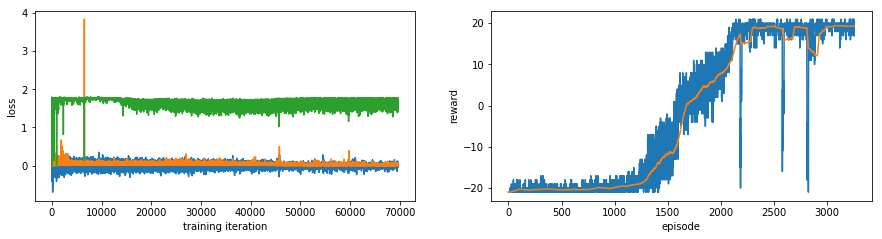

  3%|█▏                               | 348/10000 [2:08:57<59:36:31, 22.23s/it]

KeyboardInterrupt: 

In [13]:
for t in tqdm(range(10000)):
    agent.play_parallel(1000)
    plot_durations(agent)

In [14]:
agent.save("models/pong A2C")